In [1]:
import numpy as np
from numpy import sqrt
from numpy import sin
from numpy import pi
from numpy import cos
from numpy import exp
from numpy import tanh
from numpy import zeros
from numpy import arccos
from numpy import log10
from matplotlib import pyplot as plt
import scipy.optimize as opt
import emcee
from pylab import plot
from scipy import integrate
import corner
import random
from collections import Counter
import time
import scipy
from scipy.stats import poisson # use as poisson.pmf(number of events , mean value)
from scipy import optimize
import multiprocessing as mp
from multiprocessing import Pool

import astropy.units as u
import astropy.constants as c
from astropy.cosmology import FlatLambdaCDM, z_at_value
from tqdm import *
from astropy.cosmology import Planck13 as cosmo
from astropy import constants as const

In [2]:
import cmath
# we work in geometrized units
Msol = 1.47680000000000000000000000000000000 # in km
c = 1 # we have actually put them to one everywhere in the code already
G = 1
year = 60*60*24*(365.250000000000000000000000000); # s
cc = 2.9980000000000000000000000000000*10**5 # velocity of light in Km/s
pc = 3.0856770000000000000000000000*10**13 # km

H0 = 67.9 # km /s / Mpc # changed to PLANCK 2015
Omegam = 0.306
OmegaL = 0.694
Omegar = 0.

# some useful functions 
def distL(z):
    return (1+z) * integrate.quad(invE,0,z)[0] *cc / H0 *10**6*pc # km

def Ez(z):
    return sqrt(Omegar*(1+z)**4+Omegam*(1+z)**3+OmegaL)

def invE(z):
    return 1. / Ez(z)

def primopezzo(zp):
    return 1/Ez(zp)*(integrate.quad(invE,0,zp)[0])**2

def dVdz(z):
    return 4*pi*(cc/H0)**3*primopezzo(z) # Mpc**3

def dtdf(f,m1,m2):  # Hz, km, km, gravitational wave frequency
    return 5/(96*pi**(8/3))*(1./cc*(m1 + m2)*(m1*m2/(m1 + m2)**2)**(3/5))**(-5/
  3)*f**(-11/3)  # s^2, assuming f in Hz and m in km

def solof(f):
    return f**(-11/3)

def nu(m1,m2):
    return m1*m2/((m1+m2)**2)

def Mc(m1,m2):
    return (m1 + m2) * (m1*m2/((m1+m2)**2))**(3/5)

In [3]:
# Some other useful functions for frequencies, time of merger, ecc 

# frequency functions 

def fMIN2(fmax0,m1,m2,Tobs): # gravitational wave frequency
    return 1/(1/fmax0**(8/3)+256/5*(Mc(m1,m2)/cc)**(5/3)*pi**(8/3)*(Tobs))**(3/8)

def fmax(m1,m2,fmin,Tobs): # gravitational wave frequency
    return fmin*((5*cc)/(5*cc-256*fmin**(8/3)*pi**(8/3)*Tobs*Mc(m1,m2)*(Mc(m1,m2)/cc)**(2/3)))**(3/8)


# gives fmax, given fmin and Tobs. If fmax is above 10 Hz, gives 10 Hz instead. frequency is always in Hz

def getfmax(m1,m2,fmin,Tobs): # gravitational wave frequency
    if fMIN2(1,m1,m2,Tobs)>fmin:
        return fmax(m1,m2,fmin,Tobs)
    else: 
        return 1
    
def Tmerger(m1,m2,fmin): # gravitational wave frequency
    return 5. * (m1 + m2)**(1./3.) * cc**(5./3.)/ (256. * fmin**(8./3.) * m1 * m2 * pi**(8./3.))

getfmax(13.251739749586237,12.614719123231842,0.07658687835617596,10*year)
Tmerger(29*Msol,36*Msol,0.01)/year


from scipy.optimize import root_scalar
def findFmin(timemerger,m1,m2):
    def condition(fmin):
        return timemerger-Tmerger(m1,m2,fmin)
    return root_scalar(condition,bracket=(10**-4,0.1)).root



In [4]:
#here we want to add also the part with the SNR 

# LISA noise parameters
Amp = 5/10*18/10*10**-44
alpha = 138/1000
beta = -221
kappa = 521
gamma = 1680
fk = 113/10**5
L0 = 25/10*10**9
fstar = 1909/100*10**-3
pm = 10**-12

skyav=(4/5*sqrt(2)*sin(pi/3))

# noise function, checked with Mathematica

def Sacc(f):
    return (3*10**-15)**2*(1+(4/10*10**-3/f)**2)*(1+(f/(8*10**-3))**4)

def Sgal(f):
    return Amp*f**(-7/3)*exp(-f**alpha+beta*f*sin(kappa*f))*(1+tanh(gamma*(fk-f)))

def Soms(f):
    return (15. *pm)**2*(1+(2*10**-3/f)**4)  # noi: 10

def Sacc(f):
    return (3*10**-15)**2*(1+(4/10*10**-3/f)**2)*(1+(f/(8*10**-3))**4)
    
def SnSA(f):
    return 10/3*(4*Sacc(f)/(2*pi*f)**4+Soms(f))/(L0**2)*(1+6/10*(f/fstar)**2)

def R(f):
    return 3/20*2

def Sn(f):
    return abs(SnSA(f)+Sgal(f))

def Pn(f): # gravitational wave frequency
    return abs(Sn(f)*R(f))

def Aplus(iota,psi):
    return -(1+cos(iota)**2)*cos(2*psi)-2*cos(iota)*sin(2*psi)

def Across(iota,psi):
    return (1+cos(iota)**2)*sin(2*psi)-2*cos(iota)*cos(2*psi)

def Fplus(theta,phi):
    return 1/2*(1+cos(theta)**2)*cos(2*phi)

def Fcross(theta,phi):
    return cos(theta)*sin(2*phi)

def factorsky(iota,psi,theta,phi):
    return Fplus(theta,phi)*Aplus(iota,psi)+1j*Fcross(theta,phi)*Across(iota,psi)

def factorskySNR(iota,psi,theta,phi):
    return abs(sqrt(2)*sin(pi/3)*(Fplus(theta,phi)*Aplus(iota,psi)+1j*Fcross(theta,phi)*Across(iota,psi)))


In [7]:
# waveform

def ampl(m1,m2,d): 
    return (Mc(m1,m2)*G)**(5/6)*sqrt(5/24)/(pi**(2/3)*d*c**(3/2))
def habs(m1,m2,d,f): # gravitational wave frequency
    return ampl(m1,m2,d)*f**(-7/6)

#print(habs(12.4913,12.3884,10.8287*10**6*pc,1./cc))

In [9]:
# Here we define the SNR; 
# be careful that I have already put the factor for the sky average
# we use the GW only template.

def SNR(iota,psi,theta,phi,fmin,fmax,m1,m2,d): # gravitational wave frequency
    return sqrt(4*integrate.quad(lambda x: (factorskySNR(iota,psi,theta,phi)*habs(m1,m2,d, x/cc))**2/(Pn(x)*(cc**2)), fmin, fmax)[0])
#different noise here!

def SNRAverage(fmin,fmax,m1,m2,d): # gravitational wave frequency
    return sqrt(4*integrate.quad(lambda x: (skyav*habs(m1,m2,d, x/cc))**2/(Pn(x)*(cc**2)), fmin, fmax)[0])


#print(SNR(pi/4,pi/4,pi/4,pi/4,0.01,fmax(30*Msol,10*Msol,0.01,10*year),60*Msol,10*Msol,400*10**6*pc),400*10**6*pc)
#print(SNR(pi/4,pi/4,pi/4,pi/4,0.01,1,10*Msol,20*Msol,10**23))


In [10]:
eobdata = np.loadtxt('EOBmasses.dat')

NRdata = np.loadtxt('NRmasses.dat')

Phendata = np.loadtxt('PHENmasses.dat')

In [11]:
def gendistr(N,iteration,massoption,SNRth):
    

    N=int(N)
    # Define functions to store intermediate products; I haven't decided on the most convenient format for the final catalogs yet...

    massmin=50*Msol
    massmax=100*Msol

    # Largest horizon redshift; don't waste computing time above this
    zmax = 0.512
    zmin = 0.1
    # Largest comoving distance for sampling
    #??? dove la usa? -->  cdmax=astropy.cosmology.Planck15.comoving_distance(zmax).value # Mpc
    # z pdf normalization. Comoving volume at largest redshift (because comoving volume at z=0 is 0)
    # Vczhor = (astropy.cosmology.Planck15.comoving_volume(zmax)/astropy.units.Gpc**3).decompose().value #Gpc^3
    # largest merger time (yrs)
    tmax = 40
    tobs = 10
    # ground-based duty cycle
    dutycycle= 1

    data=[]
    for i in range(N):

        #Comoving distance uniform on sphere
        #while True:
        #    cd = np.sum(np.random.uniform(0, cdmax,3)**2)**0.5
        #    if cd<cdmax: break
        # Convert to redshift
        #z = astropy.cosmology.z_at_value(astropy.cosmology.Planck15.comoving_distance,cd*astropy.units.Mpc )
        # Convert to luminosity distance


        z = np.random.uniform(zmin,zmax)
        dl = distL(z)

        # Mass spectrum
        if massoption=='log': # Log flat distribution in both masses
            bothm=10**np.random.uniform(np.log10(massmin),np.log10(massmax),2)
            m1= max(bothm)
            m2= min(bothm)
        
        if massoption == 'EOB':
            index = np.random.choice(len(eobdata))
            m1 = Msol*eobdata[index][0]
            m2 = Msol*eobdata[index][1]
        
        if massoption == 'PHEN':
            index = np.random.choice(len(Phendata))
            m1 = Msol* Phendata[index][0]
            m2 = Msol*Phendata[index][1]
            
        if massoption == 'NR':
            index = np.random.choice(len(NRdata))
            m1 = Msol*NRdata[index][0]
            m2 = Msol*NRdata[index][1]
        
        if massoption=='powerlaw': # Power law with spectral index alpha in primary; uniform in secondary
            alpha=-2.3
            m1 = (massmin**(alpha+1.)+np.random.uniform(0.,1.)*(massmax**(alpha+1.)-massmin**(alpha+1.)))**(1./(alpha+1.))
            m2 = np.random.uniform(massmin,m1)
        # Sky-location, inclination, polarization, initial phase
        cosiota = random.uniform(-1.,1.)
        psi = random.uniform(0,2*pi)
        costheta=random.uniform(-1.,1.)
        phi=random.uniform(0,2*pi)
        iota=np.arccos(cosiota)
        theta=np.arccos(costheta)
        #phic = np.random.uniform(0,2.*np.pi)
        
        # Merger time
        tmerger=np.random.uniform(1*year,41*year)
        
        #fmin=np.random.uniform(1e-5,0.01)
        fmin=findFmin(tmerger,m1,m2)
        Fmax= getfmax(m1*(1+z),m2*(1+z),fmin/(1+z),tobs*year)  #fmax(m1,m2,fmin,tobs*year)
        #Fmax = 1 #Fmax=1
        snr=np.sqrt(dutycycle)*SNR(iota,psi,theta,phi,fmin/(1+z),Fmax,m1*(1+z),m2*(1+z),dl)


        # Order from Antoine's code:
        # double m1 = atof(argv[1]);
        # double m2 = atof(argv[2]);
        # double costhN = atof(argv[3]);
        # double phiN = atof(argv[4]);
        # double dist = atof(argv[5]);
        # double costhL = atof(argv[6]);
        # double phiL = atof(argv[7]);
        # double tmerger = atof(argv[8]);
        # double phic = atof(argv[9]);

        # Here I pile up together some factors in the rate integral
        #dVcdz = dVdz(z)
        dVcdz = cosmo.comoving_volume(z).value 
        integralbulk = tmax * (zmax-zmin) * dVcdz   *np.heaviside(snr-SNRth,0) * (1./(1.+z))

        data.append(np.array([m1,m2,z,fmin,integralbulk,snr]))

    return np.array(data).T



In [12]:
zP = np.random.uniform(0.1,0.512)
dlP = distL(zP)

In [13]:
tmergerP=np.random.uniform(1*year,41*year)

In [14]:
indexP = np.random.choice(len(Phendata))
m1P = Phendata[indexP][0]
m2P = Phendata[indexP][1]

In [15]:
fminP=findFmin(tmergerP,m1P,m2P)

In [16]:
cosiotaP = random.uniform(-1.,1.)
psiP = random.uniform(0,2*pi)
costhetaP=random.uniform(-1.,1.)
phiP=random.uniform(0,2*pi)
iotaP=np.arccos(cosiotaP)
thetaP=np.arccos(costhetaP)

In [17]:
FmaxP=getfmax(m1P*(1+zP),m2P*(1+zP),fminP/(1+zP),6*year)

In [18]:
SNR(iotaP,psiP,thetaP,phiP,fminP/(1+zP),FmaxP,m1P*(1+zP),m2P*(1+zP),dlP)


5.640942490568317

In [21]:
def consolidatedistr(Nsingle,iterations,massoption,SNRth):

    Nsingle = int(Nsingle)
    iterations = int(iterations)

    Ntot = Nsingle*iterations
    data=[]
    for it in range(0,iterations):
        data.append(gendistr(Nsingle,it,massoption,SNRth))

    data=np.array(data)

    #[m1,m2,z,pdetLIGO,pdetCE,tmerger,SNR4,SNR10,integralbulk]

    m1 = np.concatenate(data[:,0])
    m2 = np.concatenate(data[:,1])
    z = np.concatenate(data[:,2])
    #pdetLIGO = np.concatenate(data[:,3])
    #pdetCE = np.concatenate(data[:,4])
    #tmerger = np.concatenate(data[:,3])
    fmin = np.concatenate(data[:,3])
    #SNR4 = np.concatenate(data[:,6])
    #SNR10 = np.concatenate(data[:,7])
    integralbulk = np.concatenate(data[:,4])
    SNR10 = np.concatenate(data[:,5])

    return m1,m2,z,fmin,integralbulk,SNR10

In [22]:
def Nevents(bigdata,massoption,rateinterval):

    # bigdata is the output of consolidatedistr
    m1,m2,z,fmin,integralbulk,SNR10 = bigdata #consolidatedistr(Nsingle,iterations)

    Ntot = len(m1)


    # Intrisinc merger rate from LIGO O2 catalog. Use the numbers reported in Sec 4 of 1811.12940, which averages over the two pipelines.
    totalrate={}
    if massoption=='powerlaw':
        totalrate['median'] =  57*10**(-9)
        totalrate['upper'] = (57 + 40)*10**(-9)
        totalrate['lower'] = (57. - 25.)*10**(-9)
    if massoption=='log':
        totalrate['median'] = 0.13*10**(-9) #19.*10**(-9)
        totalrate['upper'] = (19. + 13.)*10**(-9)
        totalrate['lower'] = (19. - 8.2)*10**(-9)
        
    if massoption=='EOB' or massoption=='NR' or massoption=='PHEN':
        totalrate['median'] = 0.13*10**(-9) #19.*10**(-9)
        totalrate['upper'] = (0.13 + 0.3)*10**(-9)
        totalrate['lower'] = (0.13 - 0.11)*10**(-9)

    
    montecarlo_contributions = totalrate[rateinterval] * integralbulk / Ntot
    

    return np.sum(montecarlo_contributions)



In [23]:
Nevents(consolidatedistr(10**3,1,'EOB',8),'EOB','median')

4.7095065857686205

# Here we want to try the Gamma function to sample the rate 

In [24]:
import scipy.special as sps

Samples are drawn from a Gamma distribution with specified parameters, shape (sometimes designated “k”) and scale (sometimes designated “theta”), where both parameters are > 0.

In [31]:
year = 60 * 60 * 24 * 365

In [44]:
shape = 1 
scale = 1/(57*10**(-9))

s = np.random.gamma(shape,scale, 1000)

In [52]:
def PDF(rate, k ):
    
    scale = 1/rate
    
    t = np.random.gamma(k,scale)
    
    return t**(k-1)*(np.exp(-t/scale) /  (sps.gamma(k)*scale**k))

In [55]:
PDF((0.13*10**(-9)), 1)

9.451407044987117e-11

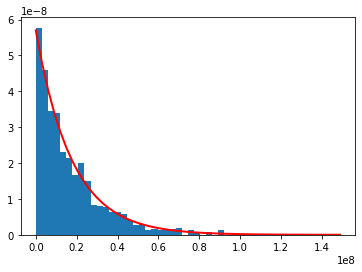

In [46]:
count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.show()